In [1]:
# Cell 1 — 加载必要库，固定随机性

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 保证所有随机操作可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Dependencies loaded. Random seed set to", RANDOM_SEED)


Dependencies loaded. Random seed set to 42


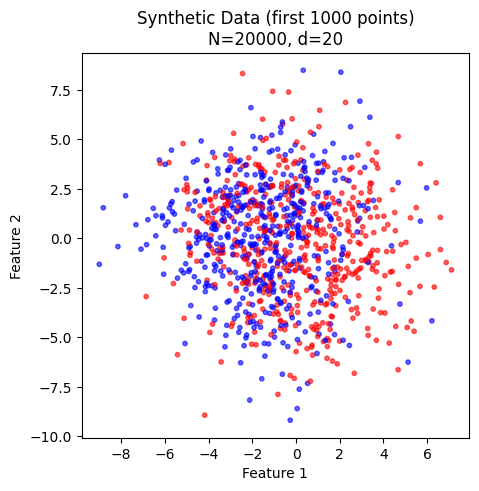

Train size: 16000, Test size: 4000


In [2]:
# Cell 2 — 生成 N=20000, d=20 的二分类数据集
N, D = 20000, 20
X, y = make_classification(
    n_samples=N,
    n_features=D,
    n_informative=15,
    n_redundant=5,
    flip_y=0.02,
    class_sep=1.5,
    random_state=RANDOM_SEED
)

# 只绘制前两维以示意整体分布
plt.figure(figsize=(5,5))
plt.scatter(X[:1000,0], X[:1000,1], c=y[:1000], cmap='bwr', s=10, alpha=0.6)
plt.title(f"Synthetic Data (first 1000 points)\nN={N}, d={D}")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.show()

# 划分训练/测试（80/20）
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)
print(f"Train size: {len(y_tr)}, Test size: {len(y_te)}")


In [3]:
# Cell 3 — 定义 sigmoid、损失 & 准确率计算

def sigmoid(z):
    """Sigmoid 函数"""
    return 1 / (1 + np.exp(-z))

def compute_loss(w, b, X, y, l2=0.0):
    """
    计算带 L2 正则的 Logistic 损失
    L = (1/N) * sum[-y log p - (1-y) log(1-p)] + (l2/2)*||w||^2
    """
    N = len(y)
    z = X.dot(w) + b
    p = sigmoid(z)
    # 防止 log(0)
    eps = 1e-12
    loss = - (y * np.log(p+eps) + (1-y)*np.log(1-p+eps)).mean()
    # L2 正则
    loss += 0.5 * l2 * np.sum(w**2)
    return loss

def accuracy(w, b, X, y):
    """计算 w,b 在 (X,y) 上的分类准确率"""
    preds = (sigmoid(X.dot(w) + b) >= 0.5).astype(int)
    return (preds == y).mean()


In [4]:
class GDClassifier:
    def __init__(self, lr=1e-2, l2=0.0):
        self.lr = lr
        self.l2 = l2

    def fit(self, X, y, epochs=50):
        N, D = X.shape
        self.w = np.zeros(D)
        self.b = 0.0
        history = []
        for ep in range(1, epochs+1):
            # 计算概率
            z = X.dot(self.w) + self.b
            p = sigmoid(z)
            # 梯度
            grad_w = (X.T.dot(p - y)) / N + self.l2 * self.w
            grad_b = (p - y).mean()
            # 更新
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
            # 记录损失
            loss = compute_loss(self.w, self.b, X, y, self.l2)
            history.append(loss)
            if ep % 10 == 0:
                print(f"[GD] Epoch {ep}: loss={loss:.4f}")
        return np.array(history)

    def predict_proba(self, X):
        """返回正类概率"""
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X):
        """返回二分类预测 (0/1)"""
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        """返回准确率"""
        return (self.predict(X) == y).mean()


In [5]:
class SGDClassifier:
    def __init__(self, lr=1e-3, l2=0.0):
        self.lr = lr
        self.l2 = l2

    def fit(self, X, y, epochs=1):
        N, D = X.shape
        self.w = np.zeros(D)
        self.b = 0.0
        history = []
        for ep in range(1, epochs+1):
            idx = np.random.permutation(N)
            for i in idx:
                xi, yi = X[i], y[i]
                pi = sigmoid(xi.dot(self.w) + self.b)
                grad_w = xi * (pi - yi) + self.l2 * self.w
                grad_b = (pi - yi)
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b
            loss = compute_loss(self.w, self.b, X, y, self.l2)
            history.append(loss)
            print(f"[SGD] Epoch {ep}: loss={loss:.4f}")
        return np.array(history)

    def predict_proba(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return (self.predict(X) == y).mean()


In [6]:
# Cell 6 — SAGAClassifier：方差消除 SGD + 预测接口

class SAGAClassifier:
    def __init__(self, lr=1e-2, l2=0.0):
        self.lr, self.l2 = lr, l2
        self.w = None
        self.b = None
        self.grad_table = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, epochs=1):
        """
        训练 SAGA 分类器
        X: [N × d], y: [N]（{0,1}）
        """
        N, D = X.shape
        # 初始化参数与梯度表
        self.w = np.zeros(D)
        self.b = 0.0
        self.grad_table = np.zeros((N, D+1))  # 存每样本的梯度

        history = []
        for ep in range(1, epochs+1):
            idx = np.random.permutation(N)
            for i in idx:
                xi, yi = X[i], y[i]
                # 当前样本预测概率
                pi = self._sigmoid(xi.dot(self.w) + self.b)
                # 样本梯度 [d] & [scalar]
                grad_w_i = xi * (pi - yi) + self.l2 * self.w
                grad_b_i = (pi - yi)
                # 合并为 [d+1]
                g_i = np.concatenate([grad_w_i, [grad_b_i]])

                # 估计全局梯度：方差消除
                table_mean = self.grad_table.mean(axis=0)      # [d+1]
                g_est = g_i - self.grad_table[i] + table_mean  # [d+1]

                # 更新参数
                self.w -= self.lr * g_est[:D]
                self.b -= self.lr * g_est[D]

                # 更新梯度表
                self.grad_table[i] = g_i

            # 每轮记录损失
            loss = compute_loss(self.w, self.b, X, y, self.l2)
            history.append(loss)
            print(f"[SAGA] Epoch {ep}: loss={loss:.4f}")
        return np.array(history)

    def predict_proba(self, X):
        """
        返回正类（1）的概率：shape [n_samples]
        """
        return self._sigmoid(X.dot(self.w) + self.b)

    def predict(self, X):
        """
        返回二分类预测（0 或 1）
        """
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        """
        预测准确率
        """
        return (self.predict(X) == y).mean()


Training GD...
[GD] Epoch 10: loss=0.4648
[GD] Epoch 20: loss=0.4005
[GD] Epoch 30: loss=0.3652
GD done in 0.0s

Training SGD...
[SGD] Epoch 1: loss=0.2068
[SGD] Epoch 2: loss=0.1943
[SGD] Epoch 3: loss=0.1895
[SGD] Epoch 4: loss=0.1875
[SGD] Epoch 5: loss=0.1856
[SGD] Epoch 6: loss=0.1852
[SGD] Epoch 7: loss=0.1863
[SGD] Epoch 8: loss=0.1839
[SGD] Epoch 9: loss=0.1844
[SGD] Epoch 10: loss=0.1837
[SGD] Epoch 11: loss=0.1936
[SGD] Epoch 12: loss=0.1827
[SGD] Epoch 13: loss=0.1854
[SGD] Epoch 14: loss=0.1816
[SGD] Epoch 15: loss=0.1830
[SGD] Epoch 16: loss=0.1820
[SGD] Epoch 17: loss=0.1848
[SGD] Epoch 18: loss=0.1825
[SGD] Epoch 19: loss=0.1819
[SGD] Epoch 20: loss=0.1829
[SGD] Epoch 21: loss=0.1864
[SGD] Epoch 22: loss=0.1836
[SGD] Epoch 23: loss=0.1820
[SGD] Epoch 24: loss=0.1809
[SGD] Epoch 25: loss=0.1845
[SGD] Epoch 26: loss=0.1816
[SGD] Epoch 27: loss=0.1861
[SGD] Epoch 28: loss=0.1843
[SGD] Epoch 29: loss=0.1820
[SGD] Epoch 30: loss=0.1837
SGD done in 2.1s

Training SAGA...
[SAGA

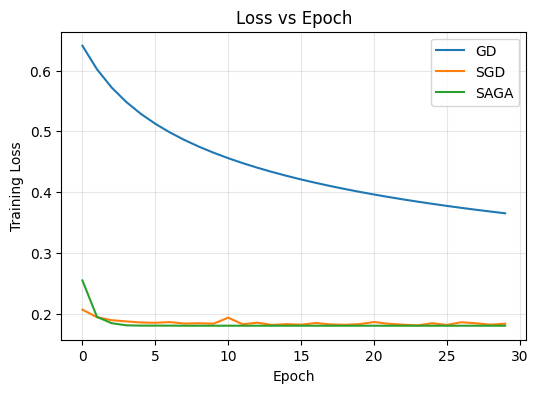

In [7]:
# Cell 7 — 训练对比并保存模型实例
epochs = 30
models = {}        # 存放每种算法的实例
results = {}       # 存放它们的 loss 曲线和时间

for name, Cls in [("GD", GDClassifier(lr=1e-2, l2=1e-4)),
                  ("SGD", SGDClassifier(lr=1e-3, l2=1e-4)),
                  ("SAGA", SAGAClassifier(lr=1e-2, l2=1e-4))]:
    print(f"Training {name}...")
    model = Cls
    start = time.time()
    history = model.fit(X_tr, y_tr, epochs=epochs)
    elapsed = time.time() - start
    models[name] = model
    results[name] = (history, elapsed)
    print(f"{name} done in {elapsed:.1f}s\n")

# 绘制 Loss vs Epoch
plt.figure(figsize=(6,4))
for name,(hist,_) in results.items():
    plt.plot(hist, label=name)
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Loss vs Epoch")
plt.legend(); plt.grid(alpha=0.3); plt.show()


In [8]:
# Cell 8 — 在测试集上评估并打印准确率
from sklearn.metrics import accuracy_score

for name, model in models.items():
    y_pred = model.predict(X_te)
    acc    = accuracy_score(y_te, y_pred)
    print(f"{name} test accuracy: {acc:.3%}")


GD test accuracy: 87.325%
SGD test accuracy: 94.500%
SAGA test accuracy: 94.525%


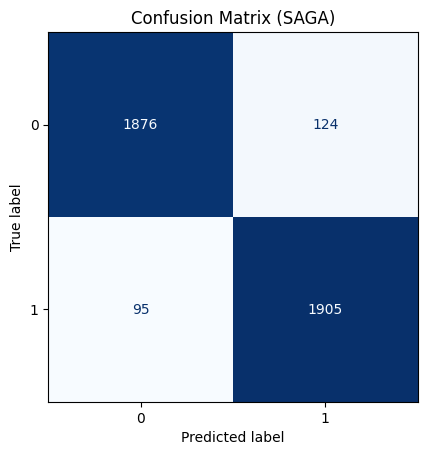

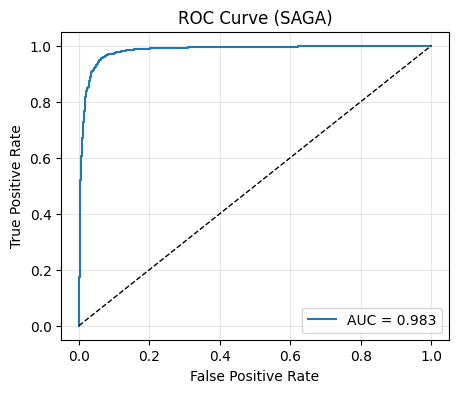

In [13]:
# Cell 9 — 混淆矩阵 & ROC 对比（SAGA 分类器）

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# —— 1) 拿到你训练好的 SAGA 分类器 ——  
# 如果你在 Cell 5 中用变量 saga.fit() 训练，就直接用 saga：
clf = models['SAGA']

# —— 2) 在测试集上预测概率和标签 ——  
# 假设测试特征和标签分别是 X_te, y_te
y_prob = clf.predict_proba(X_te)         # 正类概率 [n_samples]
y_pred = (y_prob >= 0.5).astype(int)     # 阈值 0.5 得到 0/1 预测

# —— 3) 混淆矩阵 ——  
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (SAGA)")
plt.show()

# —— 4) ROC 曲线 & AUC ——  
fpr, tpr, _ = roc_curve(y_te, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SAGA)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
